In [1]:
import csv
import json
import time
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

import researchpy as rp

import sys  
sys.path.insert(0, 'E:\Google Drive\Analises\Codigos python')
from build_features import *
import ast

from alive_progress import alive_bar
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go
import geojson

from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats.contingency import relative_risk

import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots

income_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']#,'z Unknown Income']
publication_type_order = ['Prirmary data', 'Secondary data', 'Descripitve/Opinions/Methods']#, 'Other']
who_region_hrp_order = ["HRP","AFRO","AMRO","EMRO","EURO","SEARO","WPRO"]#, "z Unknown region"]
who_region_order = ["AFRO","AMRO","EMRO","EURO","SEARO","WPRO"]#, "z Unknown region"]


C:\Users\livia\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\livia\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\livia\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def treinaModeloLogistico(banco, nome_desfecho, parametros=None,
                          titulo="", categorias=["Classe negativada", "Classe positivada"], selecao_atributos=False,
                          variaveis_adicionais_obrigatorios=[]):

    print('\n\n\n***************** Inicia treinamento de modelos **********************')
    X = banco.loc[:, banco.columns != nome_desfecho]
    y = banco.loc[:, banco.columns == nome_desfecho]
    y = y.astype('uint8')

    X_train, X_test, y_train, y_test = train_test_split(
        X, y.values.ravel(), test_size=0.3, random_state=0)

    if parametros is None:
        parametros = {
            'C': 1,
            'penalty': 'l2',
            'max_iter': 1000,
            'solver': 'lbfgs'
        }

    logreg = LogisticRegression(C=parametros['C'],  solver=parametros['solver'],
                                max_iter=parametros['max_iter'], penalty=parametros['penalty'])

    if selecao_atributos:
        logreg = LogisticRegression()
        # Build step forward feature selection
        sfs1 = sfs(logreg, k_features="best", forward=True,
                   floating=False, scoring='r2', cv=5)

        if (variaveis_adicionais_obrigatorios != []):
            X_train_1 = X_train.drop(
                variaveis_adicionais_obrigatorios, axis=1, inplace=False)
            sfs1 = sfs1.fit(X_train_1, y_train)
        else:
            sfs1 = sfs1.fit(X_train, y_train)

        X_train = X_train[list(sfs1.k_feature_names_) +
                          variaveis_adicionais_obrigatorios]
        X_test = X_test[list(sfs1.k_feature_names_) +
                        variaveis_adicionais_obrigatorios]

    logreg.fit(X_train, y_train)
        
    avaliacoes = avaliaModelo(X_test, y_test, logreg, titulo, categorias)

    return avaliacoes, logreg, X_train.columns

def avaliaModelo(X_test, y_test, modelo, titulo, categorias=["Classe negativada", "Classe positivada"]):
    y_pred = modelo.predict(X_test)

    confusion_matrix_result = pd.DataFrame(confusion_matrix(y_test, pd.Series(y_pred)))
    avaliacao_modelo = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

    imprimeMetricasMatrixConfusao(confusion_matrix_result)
    make_confusion_matrix(confusion_matrix(y_test, pd.Series(y_pred)),
                            group_names=['Verdadeiro negativo', 'Falso positivo', 'Falso negativo', 'Verdadeiro positivo'],
                            categories=categorias,
                            title=titulo)
    
    print(classification_report(y_test, y_pred))

    salvaFigCurvaRoc(X_test, y_test, modelo, titulo)

    avaliacoes = []
    avaliacoes.append(confusion_matrix_result)
    avaliacoes.append(avaliacao_modelo)
    avaliacoes.append(modelo.score(X_test, y_test))
    
    return avaliacoes


# Função para construir a Matriz de confusão
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title='modelo'):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(
            value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(
        group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        acuracia = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            sensibilidade = cf[1, 1]/sum(cf[1, :])
            especificidade = cf[0, 0]/sum(cf[0, :])
            VPP = cf[1, 1] / sum(cf[:, 1])
            VPN = cf[0, 0] / sum(cf[:, 0])
            # f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAcurácia={:0.3f}\nSensibilidade={:0.3f}\nEspecificidade={:0.3f}\nVPP={:0.3f}\nVPN={:0.3f}".format(
                acuracia, sensibilidade, especificidade, VPP, VPN)
        else:
            stats_text = "\n\nnAcurácia={:0.3f}".format(acuracia)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar,
                xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Diagnóstico obtido')
        plt.xlabel('Diagnóstico classificado pelo modelo' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

    #plt.savefig("../reports/figures/" + title + '.png', bbox_inches="tight")
    #plt.savefig("../reports/figures/" + title +
                #'_hq.png', bbox_inches="tight", dpi=600)
    
    #mlflow.log_artifact("../reports/figures/" + title + '.png')
    

def salvaFigCurvaRoc(X_test, y_test, modelo, titulo):    
        logit_roc_auc = roc_auc_score(y_test, modelo.predict(X_test))
        fpr, tpr, thresholds = roc_curve(y_test, modelo.predict_proba(X_test)[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' %  logit_roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(titulo + ' - ROC')
        plt.legend(loc="lower right")
        ##plt.savefig('../reports/figures/' + titulo + '_ROC.png')
        plt.show()
        
def imprimeMetricasMatrixConfusao(matrix_confusao):
    cm = matrix_confusao

    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    n_decimais = 3

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round(TP/(TP+FN), n_decimais)
    # Specificity or true negative rate
    TNR = round(TN/(TN+FP), n_decimais)
    # Precision or positive predictive value
    PPV = round(TP/(TP+FP), n_decimais)
    # Negative predictive value
    NPV = round(TN/(TN+FN), n_decimais)
    # Fall out or false positive rate
    FPR = round(FP/(FP+TN), n_decimais)
    # False negative rate
    FNR = round(FN/(TP+FN), n_decimais)
    # False discovery rate
    FDR = round(FP/(TP+FP), n_decimais)

    # Overall accuracy
    ACC = round((TP+TN)/(TP+FP+FN+TN), n_decimais)

    print("\nTP: " + str(TP), ", TN: " + str(TN),
          ", FP: " + str(FP), ", FN: " + str(FN),
          "\nTPR: " + str(TPR), ", TNR: " + str(TNR),
          "\nPPV: " + str(PPV), ", NPV: " + str(NPV),
          "\nFPR: " + str(FPR), ", FNR: " + str(FNR), ", FDR: " + str(FDR),
          "\nACC: " + str(ACC))
          
    resultado = {"TP": TP, "TN": TN, "FP": FP, "FN": FN, "TPR": TPR, "TNR": TNR, "PPV": PPV, "NPV": NPV, "FPR": FPR, "FNR": FNR, "FDR": FDR, "ACC": ACC}

    return resultado

def descobreLogito(banco, nome_desfecho, max_iter=1000, titulo = "modelo"):
    X = banco.loc[:, banco.columns != nome_desfecho]
    X = sm.add_constant(X)

    y = banco.loc[:, banco.columns == nome_desfecho]

    #with mlflow.start_run(run_name="{titulo}".format(titulo=titulo)) as run:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y.values.ravel(), test_size=0.3, random_state=0)

    logit_model = sm.Logit(y_train, X_train)
    result = logit_model.fit(maxiter=max_iter)
    print('\n************** Calcula Logito ********************')
    print(result.summary())

    
    ##Calcula o odds ajustado e intervalo de confianca
    conf = result.conf_int()
    conf['Odds Ratio'] = result.params
    conf.columns = ['Odds Ratio', '5%', '95%']
    odds = round(np.exp(conf),3)
    print(odds)

    return result

#def calcMultipleRR(data, outcome, column, positive_value):
#    nome_coluna = "RR (IC95%)"
#    table = rp.crosstab(data[column], data[desfecho])
#    table.columns = table.columns.droplevel()
#    RR = pd.DataFrame(columns=[nome_coluna], index = table.index, data="")
#    RR.at[table.index[0], nome_coluna] = "-"
#    
#    control = table.iloc[0]
#    for index, row in table[1:-1].iterrows():
#        exposed = row
#        result = relative_risk(exposed_cases = exposed[positive_value], exposed_total = exposed['All'], 
#                           control_cases = control[positive_value], control_total = control['All'])
#        ic = result.confidence_interval(confidence_level=0.95)
#        RR.at[index, nome_coluna] = "{} ({}-{})".format(round(result.relative_risk, 2), round(ic.low, 2), round(ic.high, 2))
#        
#    return pd.concat([table, RR], axis=1)

In [3]:
path = 'C:\\Users\\livia\\Dropbox\\HRP Alliance authorship paper\\Final data\\'

authors = pd.read_csv(path + 'paper_authors_with_affiliations.csv')
authors.head(5)
authors[authors["alpha-2"]=="RU"]

,Term,Title,Tags,Origin,pmid_l,title,authors_list,citation,journal_book,publication_year,...,total_male_authors,total_unknow_authors,total_authors,gender_proportion_per_paper,last_author_affiliation_binary,first_author_gender,type_author_2,total_per_papers_authors,publication_type_final,need_reclassify
12999,10.2471/BLT.19.238170,A combination approach of behavioural and biom...,Included by VB,VB_reports_screened,32514218,A combination approach of behavioural and biom...,"IGOR TOSKIN, NATALIIA BAKUNINA, ANTONIO CARLOS...","Toskin I, Bakunina N, Gerbase AC, et al. A com...",Bulletin of the World Health Organization,2020,...,7,0,12,0.714286,Non-HRP,male,co-author,3,z Need Classification,False


In [4]:
authors.publication_type_final.replace("z Need Classification", np.nan, inplace=True)
authors.publication_type.replace("Other", np.nan, inplace=True)
authors.last_author_affiliation.replace("unknown", np.nan, inplace=True)
authors.first_author_gender.replace("unknown", np.nan, inplace=True)
authors.last_author_gender.replace("unknown", np.nan, inplace=True)
authors.first_author_who_area.replace("z Unknown region",  np.nan, inplace=True)
authors.last_author_region.replace("z Unknown region",  np.nan, inplace=True)
authors.last_author_who_area.replace("z Unknown region",  np.nan, inplace=True)

authors.first_author_region.replace("z Unknown region",  np.nan, inplace=True)
authors.last_author_affiliation.replace("Unknown affiliation",  np.nan, inplace=True)
authors.first_author_affiliation.replace("Unknown affiliation",  np.nan, inplace=True)

authors.who_region_hrp.replace("z Unknown region",  np.nan, inplace=True)
authors.first_author_who_area_hrp.replace("z Unknown region",  np.nan, inplace=True)
authors.last_author_who_area_hrp.replace("z Unknown region",  np.nan, inplace=True)
authors.first_author_income_country.replace("z Unknown Income",  np.nan, inplace=True)
authors.last_author_income_country.replace("z Unknown Income",  np.nan, inplace=True)

In [5]:
authors['year_of_publication_2'] = ["1972-2001" if publication_year >= 1972 and publication_year <= 2001 else 
                                    "2002-2011" if publication_year >= 2002 and publication_year <= 2011 else 
                                    ">2012" for publication_year in authors.publication_year]

In [6]:
desfecho = "gender"
authors_binary = authors[authors[desfecho] != "unknown"]
tabela = rp.crosstab(authors_binary["year_of_publication"], authors_binary[desfecho])


In [7]:
tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'publication_type', 
                              probabilidade='col', 
                              calculaOR=True, calculaExatoFisher = True, 
                              dropAllColumn = True)

gender                       female            male            \
distribuição                      N         %     N         %   
publication_type                                                
Descripitve/Opinions/Methods    656  (11.96%)   564  (11.93%)   
Prirmary data                  2822  (51.43%)  2790  (59.01%)   
Secondary data                 2009  (36.61%)  1374  (29.06%)   
All                            5487  (100.0%)  4728  (100.0%)   

gender                                                                  
distribuição                 Odds Ratio (IC95%) Fisher Exact (p-value)  
publication_type                                                        
Descripitve/Opinions/Methods                  -                      -  
Prirmary data                  0.87 (0.77-0.99)                  0.029  
Secondary data                  1.26 (1.1-1.44)                  0.001  
All

In [8]:
tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'type_author', 
                              probabilidade='col', 
                              calculaOR=True, calculaExatoFisher = True, 
                              dropAllColumn = True)

gender       female            male                               \
distribuição      N         %     N         % Odds Ratio (IC95%)   
type_author                                                        
collaborator   1563  (23.49%)  1464  (24.74%)                  -   
individual     5090  (76.51%)  4453  (75.26%)   1.07 (0.99-1.16)   
All            6653  (100.0%)  5917  (100.0%)                      

gender                               
distribuição Fisher Exact (p-value)  
type_author                          
collaborator                      -  
individual                    0.103  
All

In [9]:
tabelaEstiloArtigoCategoricas(authors_binary,  desfecho, 'last_author_gender', 
                              probabilidade='col', 
                              calculaOR=True, calculaExatoFisher = True, 
                              dropAllColumn = True)

gender             female            male                               \
distribuição            N         %     N         % Odds Ratio (IC95%)   
last_author_gender                                                       
female               3171  (51.52%)  1695  (31.34%)                  -   
male                 2984  (48.48%)  3714  (68.66%)    0.43 (0.4-0.46)   
All                  6155  (100.0%)  5409  (100.0%)                      

gender                                     
distribuição       Fisher Exact (p-value)  
last_author_gender                         
female                                  -  
male                                  0.0  
All

In [10]:
tabelaEstiloArtigoCategoricas(authors_binary, 'last_author_gender', desfecho,
                              probabilidade='col', 
                              calculaOR=True, calculaExatoFisher = True, 
                              dropAllColumn = True)

last_author_gender female            male                               \
distribuição            N         %     N         % Odds Ratio (IC95%)   
gender                                                                   
female               3171  (65.17%)  2984  (44.55%)                  -   
male                 1695  (34.83%)  3714  (55.45%)   2.33 (2.16-2.51)   
All                  4866  (100.0%)  6698  (100.0%)                      

last_author_gender                         
distribuição       Fisher Exact (p-value)  
gender                                     
female                                  -  
male                                  0.0  
All

In [11]:
tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'type_author_2', 
                              probabilidade='col', 
                              calculaOR=True, calculaExatoFisher = True, 
                              dropAllColumn = True)

gender        female            male                               \
distribuição       N         %     N         % Odds Ratio (IC95%)   
type_author_2                                                       
co-author       3728  (56.03%)  3174  (53.64%)                  -   
collaborator    1563  (23.49%)  1464  (24.74%)   0.91 (0.83-0.99)   
first_author     744  (11.18%)   563   (9.51%)    1.13 (1.0-1.27)   
last_author      618   (9.29%)   716   (12.1%)   0.73 (0.65-0.83)   
All             6653  (100.0%)  5917  (100.0%)                      

gender                                
distribuição  Fisher Exact (p-value)  
type_author_2                         
co-author                          -  
collaborator                   0.029  
first_author                   0.056  
last_author                      0.0  
All

In [12]:
tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'last_author_who_area_hrp', 
                              probabilidade='col', 
                              calculaOR=True, calculaExatoFisher = True, 
                              dropAllColumn = True,
                             categories_order = who_region_hrp_order + ["All"])

gender                   female            male                               \
distribuição                  N         %     N         % Odds Ratio (IC95%)   
last_author_who_area_hrp                                                       
HRP                        1600  (36.22%)  1257   (35.8%)                  -   
AFRO                        323   (7.31%)   273   (7.78%)   0.93 (0.78-1.11)   
AMRO                       1103  (24.97%)   860  (24.49%)    1.01 (0.9-1.13)   
EMRO                         22    (0.5%)    14    (0.4%)    1.23 (0.6-2.62)   
EURO                       1226  (27.75%)   966  (27.51%)    1.0 (0.89-1.12)   
SEARO                        49   (1.11%)    49    (1.4%)    0.79 (0.51-1.2)   
WPRO                         95   (2.15%)    92   (2.62%)     0.81 (0.6-1.1)   
All                        4418  (100.0%)  3511  (100.0%)                      

gender                                           
distribuição             Fisher Exact (p-value)  
last_author_who_area_hrp                         
HRP                                           -  
AFRO                                      0.441  
AMRO                                      0.906  
EMRO                                      0.614  
EURO                                      0.977  
SEARO                                     0.256  
WPRO                                      0.172  
All

In [13]:
tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'last_author_who_area', 
                              probabilidade='col', 
                              calculaOR=True, calculaExatoFisher = True, 
                              dropAllColumn = True, 
                             categories_order = ["AFRO","AMRO","EMRO","EURO","SEARO","WPRO"] + ["All"])

gender               female            male                               \
distribuição              N         %     N         % Odds Ratio (IC95%)   
last_author_who_area                                                       
AFRO                    323   (7.31%)   273   (7.78%)                  -   
AMRO                   1103  (24.97%)   860  (24.49%)    1.08 (0.9-1.31)   
EMRO                     22    (0.5%)    14    (0.4%)   1.33 (0.64-2.86)   
EURO                   2826  (63.97%)  2223  (63.32%)    1.07 (0.9-1.28)   
SEARO                    49   (1.11%)    49    (1.4%)   0.85 (0.54-1.33)   
WPRO                     95   (2.15%)    92   (2.62%)   0.87 (0.62-1.23)   
All                    4418  (100.0%)  3511  (100.0%)                      

gender                                       
distribuição         Fisher Exact (p-value)  
last_author_who_area                         
AFRO                                      -  
AMRO                                  0.397  
EMRO                                  0.492  
EURO                                  0.408  
SEARO                                 0.447  
WPRO                                   0.45  
All

In [14]:
tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'publication_type', 
                              probabilidade='col', 
                              calculaOR=True, calculaExatoFisher = True, 
                              dropAllColumn = True,
                             categories_order = publication_type_order + ["All"])

gender                       female            male            \
distribuição                      N         %     N         %   
publication_type                                                
Prirmary data                  2822  (51.43%)  2790  (59.01%)   
Secondary data                 2009  (36.61%)  1374  (29.06%)   
Descripitve/Opinions/Methods    656  (11.96%)   564  (11.93%)   
All                            5487  (100.0%)  4728  (100.0%)   

gender                                                                  
distribuição                 Odds Ratio (IC95%) Fisher Exact (p-value)  
publication_type                                                        
Prirmary data                                 -                      -  
Secondary data                 1.45 (1.32-1.58)                    0.0  
Descripitve/Opinions/Methods    1.15 (1.01-1.3)                  0.029  
All

In [15]:
tabelaEstiloArtigoCategoricas(authors_binary,  desfecho, 'Income group', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True,
                             categories_order = income_order + ["All"])

gender              female            male                               \
distribuição             N         %     N         % Odds Ratio (IC95%)   
Income group                                                              
High income           2905  (74.81%)  1899  (62.53%)                  -   
Upper middle income    637   (16.4%)   620  (20.41%)   0.67 (0.59-0.76)   
Lower middle income    272    (7.0%)   378  (12.45%)    0.47 (0.4-0.56)   
Low income              69   (1.78%)   140   (4.61%)   0.32 (0.24-0.44)   
All                   3883  (100.0%)  3037  (100.0%)                      

gender                                      
distribuição        Fisher Exact (p-value)  
Income group                                
High income                              -  
Upper middle income                    0.0  
Lower middle income                    0.0  
Low income                             0.0  
All

In [16]:
authors_binary['publication_type_final'].value_counts().index

Index(['REVIEW', 'CROSS-SECTIONAL', 'INTERVENTION/RCT', 'COHORT STUDY',
       'COMMENT/CORRESPONDENCE', 'ESTIMATES', 'EVALUATION STUDY',
       'QUALITATIVE STUDY', 'EDITORIAL', 'STUDY PROTOCOL',
       'MIXED-METHODS STUDY', 'VALIDATION STUDY', 'CASE CONTROL STUDY',
       'STATEMENTS', 'CASE REPORTS', 'CONFERENCE PAPERS'],
      dtype='object', name='publication_type_final')

In [17]:
tabelaEstiloArtigoCategoricas(authors_binary,  desfecho, 'who_region_hrp', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)

gender         female            male                               \
distribuição        N         %     N         % Odds Ratio (IC95%)   
who_region_hrp                                                       
AFRO              309   (7.96%)   458  (15.08%)                  -   
AMRO             1174  (30.23%)   821  (27.03%)   2.12 (1.78-2.52)   
EMRO               46   (1.18%)    55   (1.81%)    1.24 (0.8-1.92)   
EURO             1084  (27.92%)   664  (21.86%)   2.42 (2.03-2.89)   
HRP              1001  (25.78%)   742  (24.43%)    2.0 (1.68-2.39)   
SEARO              97    (2.5%)   124   (4.08%)   1.16 (0.85-1.59)   
WPRO              172   (4.43%)   173    (5.7%)   1.47 (1.13-1.92)   
All              3883  (100.0%)  3037  (100.0%)                      

gender                                 
distribuição   Fisher Exact (p-value)  
who_region_hrp                         
AFRO                                -  
AMRO                              0.0  
EMRO                            0.333  
EURO                              0.0  
HRP                               0.0  
SEARO                           0.352  
WPRO                            0.003  
All

In [18]:
desfecho = "gender"
tabela_publication_type_final = tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'publication_type_final', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True,
                                                            categories_order =  ['REVIEW', 'CROSS-SECTIONAL', 'INTERVENTION/RCT', 'COHORT STUDY',
                                                           'COMMENT/CORRESPONDENCE', 'ESTIMATES', 'EVALUATION STUDY',
                                                           'QUALITATIVE STUDY', 'EDITORIAL', 'STUDY PROTOCOL',
                                                           'MIXED-METHODS STUDY', 'VALIDATION STUDY', 'STATEMENTS',
                                                           'CASE CONTROL STUDY', 'CASE REPORTS', 'CONFERENCE PAPERS'] + ["All"])
tabela_publication_type = tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'publication_type', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)
tabela_author_affiliation = tabelaEstiloArtigoCategoricas(authors_binary,desfecho, 'affiliation_hrp_binary', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)
tabela_author_position = tabelaEstiloArtigoCategoricas(authors_binary,desfecho, 'type_author_2', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)

tabela_last_author_affiliation = tabelaEstiloArtigoCategoricas(authors_binary,desfecho, 'last_author_affiliation', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)
tabela_last_author_gender = tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'last_author_gender', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)
tabela_last_author_region = tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'last_author_region', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)
tabela_last_author_who_area = tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'last_author_who_area', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)
tabela_first_author_affiliation = tabelaEstiloArtigoCategoricas(authors_binary,desfecho, 'first_author_affiliation', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)
tabela_first_author_gender = tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'first_author_gender', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)
tabela_fisrt_author_region = tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'first_author_region', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)
tabela_fisrt_author_who_area = tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'first_author_who_area', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)
tabela_year_of_publication = tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'year_of_publication', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)
tabela_year_of_publication_2 = tabelaEstiloArtigoCategoricas(authors_binary, desfecho, 'year_of_publication_2', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)

tabela_who_region_hrp = tabelaEstiloArtigoCategoricas(authors_binary, desfecho,"who_region_hrp", probabilidade='col')
tabela_fisrt_author_who_region_hrp = tabelaEstiloArtigoCategoricas(authors_binary, desfecho, "first_author_who_area_hrp", probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True,
                             categories_order = who_region_hrp_order + ["All"])
tabela_last_author_who_region_hrp = tabelaEstiloArtigoCategoricas(authors_binary,  desfecho, "last_author_who_area_hrp", probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True,
                             categories_order = who_region_hrp_order + ["All"])
tabela_author_who_region_hrp = tabelaEstiloArtigoCategoricas(authors_binary,  desfecho, "who_region_hrp", probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True,
                             categories_order = who_region_hrp_order + ["All"])

tabela_first_author_income_country = tabelaEstiloArtigoCategoricas(authors_binary, desfecho, "first_author_income_country", probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True,
                             categories_order = income_order + ["All"])
tabela_last_author_income_country = tabelaEstiloArtigoCategoricas(authors_binary,  desfecho, "last_author_income_country", probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True,
                             categories_order = income_order + ["All"])
tabela_author_income_country = tabelaEstiloArtigoCategoricas(authors_binary,  desfecho, 'Income group', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True,
                             categories_order = income_order + ["All"])

gender_proportion = rp.summary_cont(authors_binary.groupby([desfecho])['gender_proportion_per_paper'])

tabela_fisrt_last_author_who_area = tabelaEstiloArtigoCategoricas(authors_binary, 'last_author_who_area', 'first_author_who_area', probabilidade='col', calculaOR=True, calculaExatoFisher = True, dropAllColumn = True)

soma_total_female_authors = authors_binary.groupby(['first_author_affiliation_binary'])['total_female_authors'].sum()
soma_first_author_affiliation = authors_binary.groupby(['first_author_affiliation_binary'])['total_male_authors'].sum()
soma_total_unknow_authors = authors_binary.groupby(['first_author_affiliation_binary'])['total_unknow_authors'].sum()
soma_total_authors = authors_binary.groupby(['first_author_affiliation_binary'])['total_authors'].sum()
totals = pd.concat([soma_total_female_authors, soma_first_author_affiliation,soma_total_unknow_authors, soma_total_authors], axis=1).T


In [19]:
with pd.ExcelWriter(path+'/table_1_gender_OR.xlsx') as writer:  
    tabela_publication_type_final        .to_excel(writer, sheet_name='tabela_publication_type_final')
    tabela_publication_type              .to_excel(writer, sheet_name='tabela_publication_type')
    tabela_author_affiliation            .to_excel(writer, sheet_name='tabela_author_affiliation')
    tabela_author_position               .to_excel(writer, sheet_name='tabela_author_position')
    tabela_author_who_region_hrp         .to_excel(writer, sheet_name='tabela_author_who_region_hrp')
    tabela_last_author_affiliation       .to_excel(writer, sheet_name='tabela_last_author_affiliation')
    tabela_last_author_gender            .to_excel(writer, sheet_name='tabela_last_author_gender')
    tabela_last_author_region            .to_excel(writer, sheet_name='tabela_last_author_region')
    tabela_last_author_who_area          .to_excel(writer, sheet_name='tabela_last_author_who_area')
    tabela_first_author_affiliation      .to_excel(writer, sheet_name='tabela_first_author_affiliation')
    tabela_first_author_gender           .to_excel(writer, sheet_name='tabela_first_author_gender')
    tabela_fisrt_author_region           .to_excel(writer, sheet_name='tabela_fisrt_author_region')
    tabela_fisrt_author_who_area         .to_excel(writer, sheet_name='tabela_fisrt_author_who_area')
    tabela_year_of_publication           .to_excel(writer, sheet_name='tabela_year_of_publication')
    tabela_year_of_publication_2         .to_excel(writer, sheet_name='tabela_year_of_publication_2')
    tabela_fisrt_last_author_who_area    .to_excel(writer, sheet_name='tabela_fisrt_last_author_who')
    tabela_fisrt_last_author_who_area    .to_excel(writer, sheet_name='tabela_fisrt_last_author_who')
    tabela_fisrt_author_who_region_hrp   .to_excel(writer, sheet_name='tabela_fisrt_who_region_hrp')
    tabela_last_author_who_region_hrp    .to_excel(writer, sheet_name='tabela_last_who_region_hrp')
    tabela_first_author_income_country   .to_excel(writer, sheet_name='tabela_first_author_income')
    tabela_last_author_income_country    .to_excel(writer, sheet_name='tabela_last_author_income')
    tabela_author_income_country         .to_excel(writer, sheet_name='tabela_author_income')
    gender_proportion                    .to_excel(writer, sheet_name='gender_proportion')
    totals                               .to_excel(writer, sheet_name='totals')
    

In [20]:
authors_binary.columns[0:99]

Index(['Term', 'Title', 'Tags', 'Origin', 'pmid_l', 'title', 'authors_list',
       'citation', 'journal_book', 'publication_year', 'pmcid', 'doi',
       'publication_type', 'mesh_terms', 'term', 'is_systematic_review',
       'abstract', 'retrieved', 'deduplicated_name_std_l', 'VB check',
       'Unnamed: 20', 'Unnamed: 21', 'Inclusion', 'count_authors',
       'count_authors_institutions', 'count_authors_individual',
       'count_collaborators', 'count_collaborators_institutions',
       'count_collaborators_individual', 'count_authors_1',
       'count_authors_institutions_1', 'count_authors_individual_1', 'index',
       'full_name', 'affiliation', 'index_authorship', 'pmid',
       'is_institutions_name', 'last_name', 'first_letter_name',
       'standard_name', 'deduplicated_name_std', 'names_variation_std',
       'n_variacoes_std', 'countries', 'gender', 'constant', 'countries_name',
       'name', 'alpha-2', 'alpha-3', 'country-code', 'iso_3166-2', 'region',
       'sub-regi

In [21]:
variaveis = [ 
       'publication_year', 
       #'count_authors', 
       #'count_authors_individual',
       #'count_collaborators', 
       #'index_authorship', 
       #'countries', 
       #'gender',
       #'who_region_hrp',
       #'who_area',
       #'type_author',
       #'type_author_2',
       'affiliation_hrp_binary', 
       'last_author_affiliation_binary', 
       #'last_author_who_area',        
       'last_author_gender', 
       #'first_author_affiliation_binary',
       #'first_author_who_area',
       'first_author_gender',
       #'total_female_authors', 
       #'total_male_authors', 
       #'total_unknow_authors',
       #'total_authors',
       #'total_per_papers_authors', 
       'Income group',
       'type_author_2']
authors_sem_na = authors_binary[variaveis].dropna()

In [35]:
variaveis = [#"publication_type_final", 
        'publication_type',
        'affiliation_hrp_binary',
        'who_region_hrp', 
        'Income group', 
        'type_author_2', 
        #'first_author_gender', 
        'first_author_who_area',
        "first_author_income_country",
        'last_author_gender', 
        "last_author_income_country",
        'publication_year']

variaveis = ['publication_year',
        'Income group',
        'type_author_2', 
        'affiliation_hrp_binary',
        ]
authors_binary[variaveis]
print(len(authors_binary))
authors_sem_na = authors_binary[variaveis].dropna()
print(len(authors_sem_na))

12570
6920


In [39]:
banco_logistica = preparaBancoParaRegressaoLogistica(authors_sem_na)
formula = "+".join(banco_logistica.columns)

banco_logistica = banco_logistica.join(authors["gender"])
banco_logistica = banco_logistica[banco_logistica.gender != "unknown"]
banco_logistica.gender.replace({"male": 0, "female": 1}, inplace=True)
#banco_logistica

(6920, 4)

Número de instancias no banco antes de remover NAs: 6920
Número de instancias no banco após de remover NAs: 6920
Número de colunas no banco antes da criação das colunas dummys: 4
Número de colunas no banco após da criação das colunas dummys: 8
Número de instancias no banco antes de remover NAs: 6920
Número de instancias no banco após de remover NAs: 6920


In [40]:
banco_logistica.rename(columns={'Income_group_Upper middle income': 'Income_group_upper_middle_income', 
                                'Income_group_Lower middle income': 'Income_group_lower_middle_income',
                                'Income_group_Low income': 'Income_group_low_income', 
                                'affiliation_hrp_binary_Non-HRP': 'affiliation_hrp_binary_non_HRP'},
                      inplace=True)
banco_logistica.columns

Index(['Income_group_upper_middle_income', 'Income_group_lower_middle_income',
       'type_author_2_collaborator', 'type_author_2_last_author',
       'Income_group_low_income', 'type_author_2_first_author',
       'publication_year', 'affiliation_hrp_binary_non_HRP', 'gender'],
      dtype='object')

In [68]:
df = pd.DataFrame()
for coluna in banco_logistica.columns:
    if coluna != "gender":
        #print(coluna)
        res1 = smf.logit(formula="gender ~ " + coluna, 
                         data=banco_logistica, max_iter=1000).fit()
        res1.summary()

        odds_ratios = pd.DataFrame(
            {
                "OR": res1.params,
                "Lower CI": res1.conf_int()[0],
                "Upper CI": res1.conf_int()[1],
            }
        )
        print(res1.params.index[1])
        odds_ratios = np.exp(odds_ratios)
        odds_ratios["p-value"] = res1.pvalues
        pd.options.display.float_format = '{:.6f}'.format
        #print(odds_ratios.loc[coluna])
        df[coluna] = odds_ratios.loc[res1.params.index[1]]

Optimization terminated successfully.
         Current function value: 0.684330
         Iterations 4
Income_group_upper_middle_income[T.True]
Optimization terminated successfully.
         Current function value: 0.681408
         Iterations 4
Income_group_lower_middle_income[T.True]
Optimization terminated successfully.
         Current function value: 0.685248
         Iterations 4
type_author_2_collaborator[T.True]
Optimization terminated successfully.
         Current function value: 0.685329
         Iterations 4
type_author_2_last_author[T.True]
Optimization terminated successfully.
         Current function value: 0.682287
         Iterations 4
Income_group_low_income[T.True]
Optimization terminated successfully.
         Current function value: 0.685376
         Iterations 4
type_author_2_first_author[T.True]
Optimization terminated successfully.
         Current function value: 0.684077
         Iterations 4
publication_year
Optimization terminated successfully.
         Curr

In [69]:
df = df.T.sort_index()#.reset_index()
df

,OR,Lower CI,Upper CI,p-value
Income_group_low_income,0.374360,0.279473,0.501462,0.000000
Income_group_lower_middle_income,0.529868,0.449861,0.624104,0.000000
Income_group_upper_middle_income,0.765025,0.676842,0.864698,0.000018
affiliation_hrp_binary_non_HRP,0.930853,0.834188,1.038720,0.200237
publication_year,2.462972,1.685221,3.599666,0.000003
type_author_2_collaborator,0.794162,0.656827,0.960212,0.017356
type_author_2_first_author,1.137674,1.000020,1.294276,0.049965
type_author_2_last_author,0.853759,0.738021,0.987646,0.033403


In [74]:
df['label'] = ['Low income country',
    'Lower middle income country',
    'Upper middle income country',
    'Non-HRP',
    '+1 Year',
    'Part of a collaborating group',
    'First',
    'Last']

df['Group'] = ['Country income group (High IC)',
    'Country income group (High IC)',
    'Country income group (High IC)',
    'Author affiliation (Affiliated to HRP)',
    'Year of publication (1975)',
    'Author position (Any position, excluding first and last)',
    'Author position (Any position, excluding first and last)',
    'Author position (Any position, excluding first and last)']

In [75]:
df

,OR,Lower CI,Upper CI,p-value,label,Group
Income_group_low_income,0.374360,0.279473,0.501462,0.000000,Low income country,Country income group (High IC)
Income_group_lower_middle_income,0.529868,0.449861,0.624104,0.000000,Lower middle income country,Country income group (High IC)
Income_group_upper_middle_income,0.765025,0.676842,0.864698,0.000018,Upper middle income country,Country income group (High IC)
affiliation_hrp_binary_non_HRP,0.930853,0.834188,1.038720,0.200237,Non-HRP,Author affiliation (Affiliated to HRP)
publication_year,2.462972,1.685221,3.599666,0.000003,+1 Year,Year of publication (1975)
type_author_2_collaborator,0.794162,0.656827,0.960212,0.017356,Part of a collaborating group,"Author position (Any position, excluding first..."
type_author_2_first_author,1.137674,1.000020,1.294276,0.049965,First,"Author position (Any position, excluding first..."
type_author_2_last_author,0.853759,0.738021,0.987646,0.033403,Last,"Author position (Any position, excluding first..."


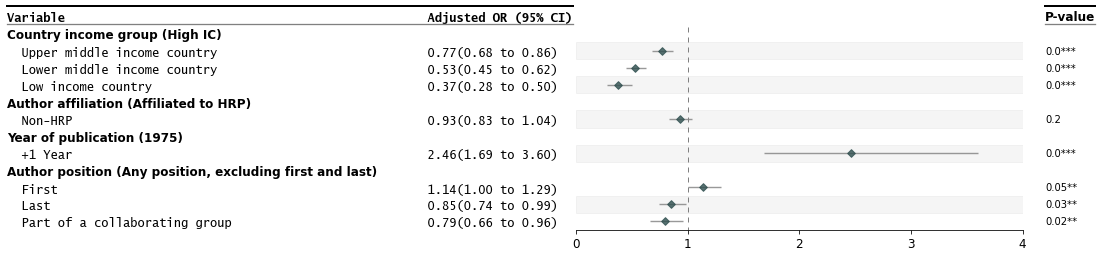

In [93]:
import forestplot as fp
fp.forestplot(df,  # the dataframe with results data
              estimate="OR",  # col containing estimated effect size 
              pval="p-value",
              ll="Lower CI", hl="Upper CI",  # columns containing conf. int. lower and higher limits
              varlabel="label",  # column containing variable label
              #ylabel="Est.(95% Conf. Int.)", #"Confidence interval",  # y-label title
              #xlabel="Adjusted Odds Ratio",  # x-label 
              xticks=[ 0, 1, 2, 3, 4],  # x-ticks to be printedddd
              #sort=True,
              groupvar="Group",
              group_order=['Country income group (High IC)',
    'Author affiliation (Affiliated to HRP)',
    'Year of publication (1975)',
    'Author position (Any position, excluding first and last)'],
              sort=True,  # sort estimates in ascending order
              table=True,  # Format as a table
              annote=[ "est_ci"],  # columns to report on left of plot
              annoteheaders=[ "Adjusted OR (95% CI)"],  # ^corresponding headers
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamondf
                 "markersize": 30,  # adjust marker size
                 "xline": 1,
                 "xlinestyle": (2, (5, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                } , 
              figsize=(8,4),color_alt_rows=True, 
              )
plt.savefig('C:\\Users\\livia\\Downloads\\FlorestPlott.png', dpi='figure', bbox_inches='tight')

In [ ]:
variaveis = ['publication_year',
        'Income group',
        'type_author_2', 
        'affiliation_hrp_binary',
        ]
authors_binary[variaveis]
print(len(authors_binary))
authors_sem_na = authors_binary[variaveis].dropna()
print(len(authors_sem_na))

banco_logistica = preparaBancoParaRegressaoLogistica(authors_sem_na)
formula = "+".join(banco_logistica.columns)

banco_logistica = banco_logistica.join(authors["gender"])
banco_logistica = banco_logistica[banco_logistica.gender != "unknown"]
banco_logistica.gender.replace({"male": 0, "female": 1}, inplace=True)
#banco_logistica

In [ ]:
res1 = smf.logit(formula="gender ~ " + formula, 
                 data=banco_logistica, max_iter=1000).fit()
res1.summary()

odds_ratios = pd.DataFrame(
    {
        "OR": res1.params,
        "Lower CI": res1.conf_int()[0],
        "Upper CI": res1.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios["p-value"] = res1.pvalues
pd.options.display.float_format = '{:.2f}'.format
odds_ratios.sort_index()


In [ ]:
##v2
formula = formula.replace('affiliation_hrp_binary_Non_HRP+', '')
formula = formula.replace('first_author_income_country_Low_income+', '')
formula = formula.replace('first_author_income_country_Upper_middle_income+', '')
formula = formula.replace('first_author_who_area_AMRO+', '')
formula = formula.replace('first_author_who_area_EMRO+', '')
formula = formula.replace('first_author_who_area_EURO+', '')
formula = formula.replace('first_author_who_area_SEARO+', '')
formula = formula.replace('last_author_income_country_Lower_middle_income+', '')
formula = formula.replace('last_author_income_country_Upper_middle_income+', '')
formula = formula.replace('publication_type_Prirmary_data+', '')
formula = formula.replace('type_author_2_collaborator+', '')
formula = formula.replace('type_author_2_first_author+', '')
formula = formula.replace('who_region_hrp_EMRO+', '')
formula = formula.replace('who_region_hrp_EURO+', '')
formula = formula.replace('who_region_hrp_HRP+', '')
formula = formula.replace('who_region_hrp_SEARO+', '')
formula = formula.replace('who_region_hrp_WPRO+', '')

##v3
formula = formula.replace('first_author_income_country_Lower_middle_income+', '')
formula = formula.replace('+last_author_income_country_Low_income', '')


formula

In [ ]:
import statsmodels.formula.api as smf
res1 = smf.logit(formula="gender ~ " + formula, 
                 data=banco_logistica, max_iter=1000).fit()
res1.summary()

odds_ratios = pd.DataFrame(
    {
        "OR": res1.params,
        "Lower CI": res1.conf_int()[0],
        "Upper CI": res1.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios["p-value"] = res1.pvalues
pd.options.display.float_format = '{:.2f}'.format
odds_ratios.sort_index()

In [ ]:
banco_logistica = preparaBancoParaRegressaoLogistica(authors_sem_na)

banco_logistica_no_last = banco_logistica[banco_logistica.type_author_2_last_author != 1]
banco_logistica_no_last.drop(["type_author_2_last_author"], axis = 1, inplace = True)

formula = "+".join(banco_logistica_no_last.columns)

banco_logistica_no_last = banco_logistica_no_last.join(authors["gender"])
banco_logistica_no_last = banco_logistica_no_last[banco_logistica_no_last.gender != "unknown"]
banco_logistica_no_last.gender.replace({"male": 0, "female": 1}, inplace=True)

formula

In [30]:
##v2
formula = formula.replace('affiliation_hrp_binary_Non_HRP+', '')
formula = formula.replace('first_author_income_country_Upper_middle_income+', '')
formula = formula.replace('first_author_who_area_EMRO+', '')
formula = formula.replace('first_author_who_area_SEARO+', '')
formula = formula.replace('last_author_income_country_Lower_middle_income+', '')
formula = formula.replace('publication_type_Prirmary_data+', '')
formula = formula.replace('type_author_2_collaborator+', '')
formula = formula.replace('type_author_2_first_author+', '')
formula = formula.replace('who_region_hrp_EMRO+', '')
formula = formula.replace('who_region_hrp_HRP+', '')
formula = formula.replace('who_region_hrp_SEARO+', '')
formula = formula.replace('+last_author_income_country_Low_income', '')

##v3
formula = formula.replace('first_author_income_country_Low_income+', '')
formula = formula.replace('first_author_who_area_AMRO+', '')
formula = formula.replace('last_author_income_country_Upper_middle_income+', '')
formula = formula.replace('who_region_hrp_EURO+', '')
formula = formula.replace('who_region_hrp_WPRO+', '')

#v4
formula = formula.replace('first_author_income_country_Lower_middle_income', '')
formula = formula.replace('first_author_who_area_EURO', '')


formula

'Income_group_Upper middle income+Income_group_Lower middle income+type_author_2_last_author+Income_group_Low income+publication_year+affiliation_hrp_binary_Non-HRP'

In [ ]:
res1 = smf.logit(formula="gender ~ " + formula, 
                 data=banco_logistica_no_last, max_iter=1000).fit()
res1.summary()

odds_ratios = pd.DataFrame(
    {
        "OR": res1.params,
        "Lower CI": res1.conf_int()[0],
        "Upper CI": res1.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios["p-value"] = res1.pvalues
pd.options.display.float_format = '{:.2f}'.format
odds_ratios.sort_index()

In [ ]:
 ##Calcula o odds ajustado e intervalo de confianca
conf = res1.conf_int()
conf['Odds Ratio'] = res1.params
conf.columns = ['Odds Ratio', '95%', '5%']
odds = np.exp(conf)
pd.options.display.float_format = '{:.2f}'.format
odds[['Odds Ratio', '5%', '95%']]

In [ ]:
import statsmodels.formula.api as smf
res1 = smf.logit(formula="""gender ~ first_author_gender_male + last_author_gender_male + type_author_2_first_author + 
                            type_author_2_last_author + type_author_2_collaborator + affiliation_hrp_binary_Non_HRP + 
                            Income_group_Upper_middle_income + Income_group_Lower_middle_income + 
                            Income_group_Low_income + publication_type_Prirmary_data + publication_type_Secondary_data + 
                            publication_year + last_author_affiliation_binary_Non_HRP
                             + 
                            first_author_gender_male:type_author_2_first_author + 
                           last_author_gender_male:type_author_2_last_author""", 
                 data=banco_logistica, max_iter=1000).fit()

res1.summary()
odds_ratios = pd.DataFrame(
    {
        "OR": res1.params,
        "Lower CI": res1.conf_int()[0],
        "Upper CI": res1.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios["p-value"] = res1.pvalues
pd.options.display.float_format = '{:.2f}'.format
odds_ratios.sort_index()

In [ ]:
tabelaEstiloArtigoCategoricas(banco_logistica_no_last, 'last_author_gender_female', desfecho,
                              probabilidade='col', calculaRR=True)#, dropAllColumn = True)

In [ ]:
first_authors = authors[authors.index_authorship > 0]
first_authors.sort_values("index_authorship", inplace=True)
first_authors = first_authors.drop_duplicates("pmid")

first_authors.head(2)

first_authors.index_authorship.value_counts()

In [ ]:
first_authors.columns[58:]

In [ ]:
first_authors['total_female_authors', 'total_male_authors']

In [ ]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(11, 6))

# Cores dos boxplot
colors = ['#6890F0', '#705898', '#98D8D8']

# plotviolin das espécies em relação ao tamanho das sépalas
ax = sns.boxplot( x = "last_author_gender", y ="total_male_authors",data = first_authors, linewidth=5, palette=colors)

# Gráfico de disperção
ax = sns.stripplot(x = "last_author_gender", y ="total_male_authors", hue="last_author_gender", data = first_authors)  

# Adicionando Título ao gráfico
plt.title("Boxplot da base de dados Íris", loc="center", fontsize=18)
plt.xlabel("Last author gender")
plt.ylabel("Total of female authors")

plt.show()

In [ ]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(11, 6))

# Cores dos boxplot
colors = ['#710c04', "lightgray"]

papers_long = pd.melt(first_authors[["total_female_authors", "total_male_authors","last_author_gender"]], id_vars = "last_author_gender")

sns.boxplot(x='last_author_gender', y='value', hue='variable', data=papers_long, #showfliers=False, 
            palette=colors)
# Gráfico de disperção

# Adicionando Título ao gráfico
plt.title("Boxplot", loc="center", fontsize=18)
plt.xlabel("Last author gender")
plt.ylabel("Total of authors")

plt.show()

In [ ]:
first_authors['total_female_percentage'] = first_authors['total_female_authors']/(first_authors['total_female_authors'] + first_authors['total_male_authors'])
first_authors['total_male_percentage'] = first_authors['total_male_authors']/(first_authors['total_female_authors'] + first_authors['total_male_authors'])

In [ ]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(11, 6))

# Cores dos boxplot
colors = ['#710c04', "lightgray"]

papers_long = pd.melt(first_authors[["total_female_percentage", "total_male_percentage","last_author_gender"]], id_vars = "last_author_gender")

sns.boxplot(x='last_author_gender', y='value', hue='variable', data=papers_long, palette=colors)
# Gráfico de disperção

# Adicionando Título ao gráfico
plt.title("Boxplot", loc="center", fontsize=18)
plt.xlabel("Last author gender")
plt.ylabel("Total of authors")

plt.show()

In [ ]:
first_authors['gender_proportion_per_paper']

# Inverting last author gender

In [ ]:
banco_logistica_no_last["last_author_gender_female"] =  banco_logistica_no_last["last_author_gender_male"].replace([0,1], [1,0])

res1 = smf.logit(formula="""gender ~ last_author_gender_female + type_author_2_first_author + 
                            type_author_2_collaborator + affiliation_hrp_binary_Non_HRP + 
                            Income_group_Upper_middle_income + Income_group_Lower_middle_income + 
                            Income_group_Low_income + publication_type_Prirmary_data + publication_type_Secondary_data + 
                            publication_year + last_author_affiliation_binary_Non_HRP""", 
                 data=banco_logistica_no_last, max_iter=1000).fit()

res1.summary()

In [ ]:
 ##Calcula o odds ajustado e intervalo de confianca
conf = res1.conf_int()
conf['Odds Ratio'] = res1.params
conf.columns = ['Odds Ratio', '95%', '5%']
odds = np.exp(conf)
pd.options.display.float_format = '{:.2f}'.format
odds[['Odds Ratio', '5%', '95%']]

In [ ]:
authors_binary_non_hrp = authors_binary[authors_binary.who_region_hrp != "HRP"]
len(authors_binary_non_hrp)

In [ ]:
tabelaEstiloArtigoCategoricas(authors_binary_non_hrp, 'gender',"Income group", probabilidade='col').loc[income_order+["All"]]

In [ ]:
with pd.ExcelWriter(path+'/table_country_1.xlsx') as writer:  
    tabelaEstiloArtigoCategoricas(authors_binary_non_hrp,  'gender',"name", probabilidade='col').sort_values(('female', 'N'), ascending = False) \
    .to_excel(writer, sheet_name='tabela_publication_type_final')

In [ ]:
banco = authors_binary_non_hrp[['pmid', 'gender', 'alpha-2', "country"]].groupby(by=["alpha-2", "gender","country"]).count().reset_index()
banco = banco.pivot(index="alpha-2", columns=["gender"], values="pmid").fillna(0)
banco["total"] = [row["female"] + row["male"] for index, row in banco.iterrows()]
banco["female_prop"] = [row["female"]/row["total"]*100 for index, row in banco.iterrows()]
banco = banco.reset_index()

#banco = banco[banco["alpha-2"] != "CH"]

banco

In [ ]:
contries_info = pd.read_csv(path + "..\\Reviewed Files\\countries.csv")

contries_info["country"] = [(country).upper() for country in contries_info.name]

contries_info.at[contries_info.country == "Palestine, State of".upper(), "country"] = "PALESTINE"
contries_info.at[contries_info.country == "United Arab Emirates".upper(), "country"] = "ARAB EMIRATES"
contries_info.at[contries_info.country == "Bolivia (Plurinational State of)".upper(), "country"] = "BOLIVIA"
contries_info.at[contries_info.country == "Korea, Republic of".upper(), "country"] = "SOUTH KOREA"
contries_info.at[contries_info.country == "Iran (Islamic Republic of)".upper(), "country"] = "IRAN"
contries_info.at[contries_info.country == "Viet Nam".upper(), "country"] = "VIETNAM"
contries_info.at[contries_info.country == "United Kingdom of Great Britain and Northern Ireland".upper(), "country"] = "UNITED KINGDOM"
contries_info.at[contries_info.country == "Congo, Democratic Republic of the".upper(), "country"] = "REPUBLIC OF THE CONGO"
contries_info.at[contries_info.country == "Congo".upper(), "country"] = "REPUBLIC OF CONGO"
contries_info.at[contries_info.country == "Moldova, Republic of".upper(), "country"] = "REPUBLIC OF MOLDOVA"        
contries_info.at[contries_info.country == "Tanzania, United Republic of".upper(), "country"] = "TANZANIA"  
contries_info.at[contries_info.country == "Russian Federation".upper(), "country"] = 'RUSSIAN FEDERATION'
    
print()
banco = pd.merge(banco, contries_info, how="left", left_on="alpha-2", right_on="alpha-2")

who_regions = pd.read_csv(path + "../Reviewed Files/WHO_LMCI_HIC_2.csv")
banco = pd.merge(banco, who_regions, how="left", left_on="alpha-3", right_on="iso3")

In [ ]:
banco.head(2)

In [ ]:
banco[["name", "female","male", "total", "female_prop"]].sort_values(["female", "male"], ascending=False)
income = banco[["Income group", "female","male", "total"]].groupby("Income group").sum().sort_values(["female", "male"], ascending=False)

with pd.ExcelWriter(path+'/table_country_2.xlsx') as writer:  
    banco[["name", "female","male", "total", "female_prop"]].sort_values(["female", "male"], ascending=False) \
        .to_excel(writer, sheet_name='tabela_publication_type_final')
    income.to_excel(writer, sheet_name='income_type_per_gender')

In [ ]:
income

In [ ]:
banco["iso_alpha2"] = banco["alpha-2"]

fig = px.scatter(
    banco,
    x="total",
    y="female_prop",
    hover_name="iso_alpha2",
    #hover_data=["lifeExp", "gdpPercap", "pop"], 
    #log_x=True
)
fig.update_traces(marker_color="rgba(0,0,0,0)")

minDim = banco[["total", "female_prop"]].max().idxmax()
maxi = banco[minDim].max()
for i, row in banco.iterrows():
    country_iso = row["iso_alpha2"]
    fig.add_layout_image(
        dict(
            source=f"https://raw.githubusercontent.com/matahombres/CSS-Country-Flags-Rounded/master/flags/{country_iso}.png",
            xref="x",
            yref="y",
            xanchor="center",
            yanchor="middle",
            x=row["total"],
            y=row["female_prop"],
            sizex=40,#np.sqrt(row["total"] / banco["total"].max()) * maxi * 0.15 + maxi * 0.03,
            sizey=50,#np.sqrt(row["total"] / banco["total"].max()) * maxi * 0.15+ maxi * 0.03,
            sizing="contain",
            opacity=0.8,
            layer="above"
        )
    )

#fig.update_layout(height=1000, width=1000, plot_bgcolor="#FFF", yaxis_range=[-5, 105])

#fig.show()

In [ ]:
banco = authors_binary_non_hrp[['pmid', 'gender', 'alpha-3']].groupby(by=["alpha-3", "gender"]).count().reset_index()
banco = banco.pivot(index="alpha-3", columns="gender", values="pmid").fillna(0)
banco["total"] = [row["female"] + row["male"] for index, row in banco.iterrows()]
banco["female_prop"] = [row["female"]/row["total"]*100 for index, row in banco.iterrows()]
banco = banco.reset_index()

banco = banco[banco["alpha-3"] != "Switzerland"]

banco.total.max()

In [ ]:
fig = px.choropleth(banco, locations="alpha-3", color="total",
                     hover_name="alpha-3",
                     color_continuous_scale=['lightgray','#710c04'],
                      title = "Total of authors per country",
                   range_color=(banco.total.min(),banco.total.max()))
fig.show()

In [ ]:
fig = px.choropleth(banco, locations="alpha-3", color="female",
                     hover_name="alpha-3",
                     color_continuous_scale=['lightgray','#710c04'],
                      title = "Female authorship",
                   range_color=(banco.total.min(),banco.total.max()))
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Total of<br /> women's authorship<br />"))

fig.show()

In [ ]:
fig = px.choropleth(banco, locations="alpha-3", color="male",
                     hover_name="alpha-3",
                     color_continuous_scale=['lightgray','#710c04'],
                      title = "Male authorship proportion per country",
                   range_color=(banco.total.min(),banco.total.max()))
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Total of<br /> men's authorship"))

fig.show()

In [ ]:
fig = px.choropleth(banco, locations="alpha-3", color="female_prop",
                     hover_name="alpha-3",
                     color_continuous_scale=['lightgray','#710c04'],
                      title = "Female authorship proportion per country")
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Percentage of<br /> women's authorship<br />  %"))

fig.show()

In [ ]:
desfecho = "gender"

first_authors = authors[authors.index_authorship > 0]
first_authors.sort_values("index_authorship", inplace=True)
first_authors = first_authors.drop_duplicates("pmid")

first_authors = first_authors[first_authors[desfecho] != "unknown"]


#first_authors = authors[(authors.groupby(['pmid'])['index_authorship'].transform(min) == authors['index_authorship'])]
first_authors.head(2)

first_authors.index_authorship.value_counts()

In [ ]:
banco = first_authors[['pmid', 'gender', 'alpha-3']].groupby(by=["alpha-3", "gender"]).count().reset_index()
banco = banco.pivot(index="alpha-3", columns="gender", values="pmid").fillna(0)
banco["total"] = [row["female"] + row["male"] for index, row in banco.iterrows()]
banco["female_prop"] = [row["female"]/row["total"]*100 for index, row in banco.iterrows()]
banco = banco.reset_index()

In [ ]:
fig = px.choropleth(banco, locations="alpha-3", color="female_prop",
                     hover_name="alpha-3",
                     color_continuous_scale=['lightgray','#710c04'],
                      title = "Female as first author proportion per country")
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Percentage of<br /> women's authorship<br />  %"))

fig.show()

In [ ]:
desfecho = "gender"

last_authors = authors[authors.index_authorship > 0]
last_authors.sort_values("index_authorship", inplace=True)
last_authors = last_authors.drop_duplicates("pmid", keep='last')

last_authors = last_authors[last_authors[desfecho] != "unknown"]

last_authors.head(2)

banco = last_authors[['pmid', 'gender', 'alpha-3']].groupby(by=["alpha-3", "gender"]).count().reset_index()
banco = banco.pivot(index="alpha-3", columns="gender", values="pmid").fillna(0)
banco["total"] = [row["female"] + row["male"] for index, row in banco.iterrows()]
banco["female_prop"] = [row["female"]/row["total"]*100 for index, row in banco.iterrows()]
banco = banco.reset_index()
#last_authors.index_authorship.value_counts()

fig = px.choropleth(banco, locations="alpha-3", color="female_prop",
                     hover_name="alpha-3",
                     color_continuous_scale=['lightgray','#710c04'],
                      title = "Female as last author proportion per country")
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Percentage of<br /> women's authorship<br />  %"))

fig.show()